In [1]:
import tensorflow as tf
import numpy as np
import scipy.misc
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

In [2]:
(X_train_orig, Y_train_orig), (X_test_orig, Y_test_orig) = tf.keras.datasets.cifar10.load_data()

# Normalize image vectors
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.

X_train = tf.image.resize(X_train, [64,64])

X_test = tf.image.resize(X_test, [64,64])

# Convert training and test labels to one hot matrices
Y_train = tf.one_hot(Y_train_orig, 10)
Y_train = np.squeeze(Y_train)
Y_test = tf.one_hot(Y_test_orig, 10)
Y_test = np.squeeze(Y_test)

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

170498071/170498071 [==============================] - 4s 0us/step
number of training examples = 50000
number of test examples = 10000
X_train shape: (50000, 64, 64, 3)
Y_train shape: (50000, 10)
X_test shape: (10000, 64, 64, 3)
Y_test shape: (10000, 10)


In [3]:
def identity_block(X, f, filters, initializer=random_uniform):

    F1, F2, F3 = filters

    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    ## Second component of main path
    X = Conv2D(filters = F2, kernel_size = f, strides = (1,1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    ## Third component of main path
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)

    ## Final step:
    X =  Add()([X_shortcut,X])
    X =  Activation('relu')(X)

    return X


def convolutional_block(X, f, filters, s = 2, initializer=glorot_uniform):

    F1, F2, F3 = filters

    X_shortcut = X

    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters =F2,  kernel_size = f, strides = (1,1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization()(X)

    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(filters= F3,kernel_size = 1 , strides = (s,s), padding = 'valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization()(X_shortcut)

    # Final step
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X


def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE

    Returns:
    model -- a Model() instance in Keras
    """

    X_input = Input(input_shape)


    # Zero-Padding

    X = ZeroPadding2D((3, 3))(X_input)
    # Stage 1

    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

     ## Stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], s=2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    ## Stage 4
    X = convolutional_block(X, f=3,filters= [256, 256, 1024], s=2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    ## Stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], s=2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])
    X = AveragePooling2D((2, 2), name='avg_pool')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model
model = ResNet50(input_shape = (64, 64, 3), classes = 10)
print(model.summary())
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 70, 70, 3)            0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           9472      ['zero_padding2d[0][0]']      
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 64)           256       ['conv2d[0][0]']          

Epoch 1/30
1563/1563 [==============================] - 126s 51ms/step - loss: 1.9781 - accuracy: 0.3661
Epoch 2/30
1563/1563 [==============================] - 81s 52ms/step - loss: 1.5573 - accuracy: 0.4775
Epoch 3/30
1563/1563 [==============================] - 81s 52ms/step - loss: 1.6192 - accuracy: 0.4634
Epoch 4/30
1563/1563 [==============================] - 82s 53ms/step - loss: 1.4639 - accuracy: 0.5180
Epoch 5/30
1563/1563 [==============================] - 82s 52ms/step - loss: 1.2212 - accuracy: 0.5917
Epoch 6/30
1563/1563 [==============================] - 81s 52ms/step - loss: 1.1624 - accuracy: 0.6091
Epoch 7/30
1563/1563 [==============================] - 80s 51ms/step - loss: 1.0278 - accuracy: 0.6569
Epoch 8/30
1563/1563 [==============================] - 81s 52ms/step - loss: 0.8869 - accuracy: 0.7050
Epoch 9/30
1563/1563 [==============================] - 81s 52ms/step - loss: 0.8625 - accuracy: 0.7073
Epoch 10/30
1563/1563 [==============================] - 80s 51

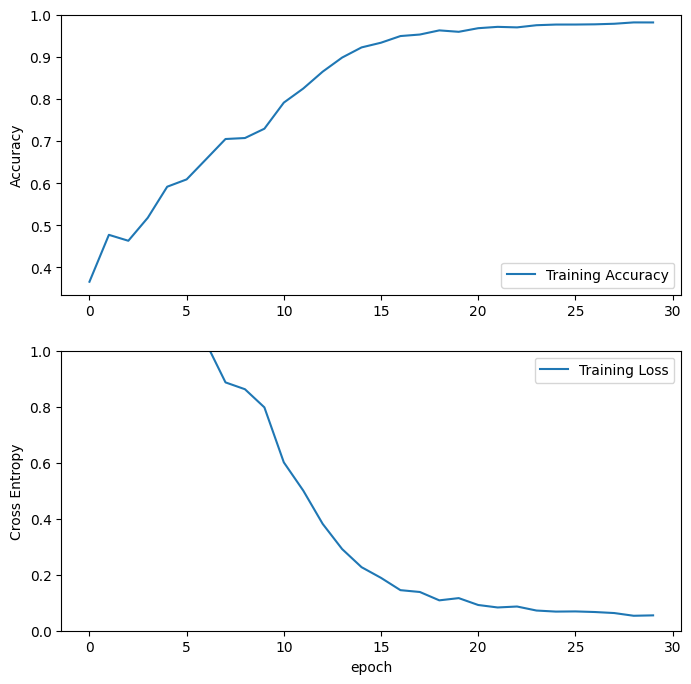

In [4]:
history = model.fit(X_train, Y_train, epochs = 30, batch_size = 32)

acc = history.history['accuracy']

loss = history.history['loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])


plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')

plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])

plt.xlabel('epoch')
plt.show()

In [5]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

313/313 [==============================] - 8s 16ms/step - loss: 1.6750 - accuracy: 0.7154
Loss = 1.675028681755066
Test Accuracy = 0.715399980545044


In [6]:
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
count=0
for number in range(1000):
    prediction=model.predict(tf.reshape(X_test[number],(1,64,64,3)))
    cls = np.argmax(prediction)
    if (cls!=Y_test_orig[number]):
        count+=1
print(count)

1/1 [==============================] - 0s 31ms/step
265


Enter a random number between 0 and 10000 and check the image prediction from Test Set : 5
1/1 [==============================] - 0s 22ms/step
[[1.8483155e-06 6.1376163e-08 3.5671107e-04 1.3779613e-04 7.5703133e-06
  2.3216325e-04 9.9917150e-01 6.3349798e-05 1.0456740e-05 1.8450284e-05]]
Predicted class :  frog 
Original class :  frog


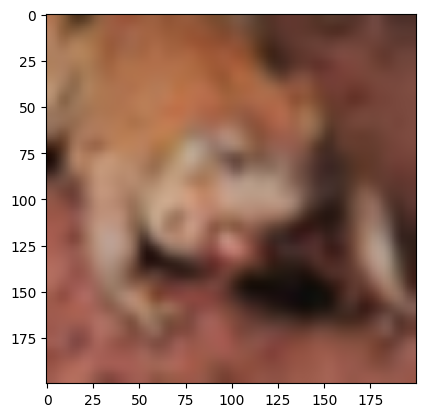

In [7]:
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
number = int(input("Enter a random number between 0 and 10000 and check the image prediction from Test Set : "))
image = tf.image.resize(X_test[number],[200,200])
plt.imshow(image)
prediction=model.predict(tf.reshape(X_test[number],(1,64,64,3)))
print(prediction)
print("Predicted class : ",classes[np.argmax(prediction)],"\nOriginal class : ",classes[Y_test_orig[number][0]])

Saving bird2.jpg to bird2.jpg
1/1 [==============================] - 0s 51ms/step


Predicted class :  Ship 
Probability :  0.99978477 



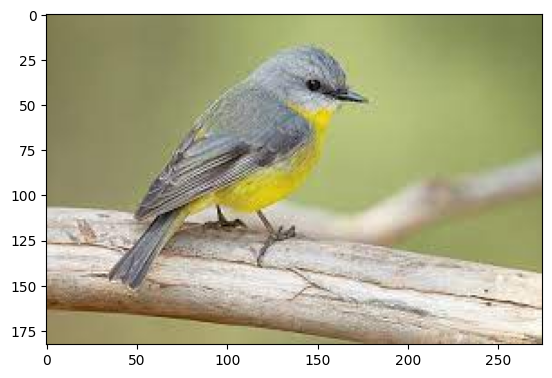

In [10]:
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array
import os
from google.colab import files

uploaded = files.upload()
for fn in uploaded.keys():
    name = fn

classes = ['Airplane','Automobile','Bird','Cat','Deer','Dog','Frog','Horse','Ship','Truck']

image = Image.open(name)
plt.imshow(image)

def make_square(im, min_size=64, fill_color=(255, 255, 255)):
    x, y = im.size
    size = max(min_size, x, y)
    new_im = Image.new('RGB', (size, size), fill_color)
    new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
    return new_im

image = make_square(image)
image = img_to_array(image)
image = tf.image.resize(image,[64,64])/255.0
prediction = model.predict(tf.reshape(image,(1,64,64,3)))
print("\n\nPredicted class : ",classes[np.argmax(prediction)],"\nProbability : ",prediction[0][np.argmax(prediction)],"\n")
os.remove(name)

In [11]:

model.save("/content/drive/MyDrive/Digit Recognition/model_resnet_cifar10.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
